# INSTALL PACKAGES

In [ ]:
import os
import email
import random
import email.policy
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import sklearn
from nltk.corpus import stopwords
import nltk
from textblob import TextBlob
nltk.download('stopwords')
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB
import seaborn as sns

# Read Data

In [8]:
base_directory = "./drive/MyDrive/AI/Email Spam Detction/data/"
spam_emails = os.listdir(base_directory + "spam")
ham_emails = os.listdir(base_directory + "ham")
# Read the emails

def load_email(is_spam, filename):
    directory = base_directory + ("spam" if is_spam else "ham")
    with open(os.path.join(directory, filename), "rb") as f:
        # print(os.path.join(directory, filename))
        return email.parser.BytesParser(policy=email.policy.default).parse(f)
    
spam_emails = [load_email(True, filename) for filename in spam_emails]
ham_emails = [load_email(False, filename) for filename in ham_emails]

print("# of SPAM emails", len(spam_emails))
print("# of HAM emails", len(ham_emails))

# of SPAM emails 501
# of HAM emails 2552


# Extracting Details from each email

In [10]:
def process_email(emails, label, data_dictionary, default_topic=None):
    for mail in emails:
        payload = mail.get_payload()
        if isinstance(payload, list):
            process_email(payload, label, data_dictionary, default_topic=mail["Subject"])
        else:
            if "Content-Type" in mail.keys():
                if "html" in mail["Content-Type"].lower():
                    try: 
                        soup = BeautifulSoup(mail.get_content())
                        topic = mail["Subject"]
                        if topic == None:
                            topic = default_topic
                        content = soup.body.text
                        data_dictionary["subject"].append(topic)
                        data_dictionary["content"].append(content)
                        data_dictionary["label"].append(label)
                    except:
                        pass
                elif "plain" in mail["Content-Type"].lower():
                    try: 
                        topic = mail["Subject"]
                        if topic == None:
                            topic = default_topic
                        content = mail.get_content()
                        data_dictionary["subject"].append(topic)
                        data_dictionary["content"].append(content)
                        data_dictionary["label"].append(label)
                    except:
                        pass
                else:
                    pass

# define disctionary stucture
emails_dictionary = {"subject": [], "content": [], "label": []}
# Get Email Contents
process_email(spam_emails, 1, emails_dictionary)
process_email(ham_emails, 0, emails_dictionary)
# Convert Dictionaryt o DataFrame
emails_df = pd.DataFrame(emails_dictionary)
emails_df.head()

,subject,content,label
0,"New, easy to use web conferencing software",\n\n\n\n\n\nUNLIMITED WEB CONFERENCING\nSubscr...,1
1,Take your Marketing to the Next Level,\n\n\n\n<!5122qHWL1-032pyeM4045IIgM3-001oYhw09...,1
2,[����] ���� �ߴ� ���� Best 5 & �ڰ��� ���� ��ǳ,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n 요즘 뜨는 직종 Be...,1
3,A better investment than the stock market.,All our mailings are sent complying to the pro...,1
4,"zzzz, Is Your web Site Making Money! 2:18:15 P...",IS YOUR BUSINESS MAKING MONEY!\nSet Up To Acce...,1


# Data Pre-Processing
Remove unwanted details 



In [11]:
def pre_process(text):
    """
      cleans the text data in the email
    """
    text = text.lower()
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    text = re.sub('[^A-Za-z]+', ' ', text)
    text = re.sub(r"(\#\w+)", "", text)
    text = re.sub(r"(\@\w+)", "", text)
    text = re.sub(r"\S*https?:\S*", "", text)
    text = re.sub("http\S+","",text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(' s ',' ',text)
    text = re.sub(r"rt ", "", text)
    text = text.lstrip().rstrip()
    return text

In [ ]:
cleaned_data = []
for s in emails_df['content']:
    try:
        cleaned_data.append(pre_process(s))
    except:
        cleaned_data.append("")

cleaned_data[:5]

# Model Starts Here :😁

In [14]:
tfidfconverter = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
content_idf = tfidfconverter.fit_transform(cleaned_data).toarray()

content_idf[:10]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.21638982, 0.        ,
        0.        ]])

In [15]:
content_idf.shape

(2669, 1000)

### Split Data

In [16]:
# features
y = emails_df['label']
X_train, X_test, y_train, y_test = train_test_split(content_idf, y, test_size=0.2, random_state=0)
print("Length of Train", len(X_train))
print("Length of Train", len(X_test))

Length of Train 2135
Length of Train 534


### Using Gaussian Naive Biase Classifier to train the model

In [17]:
#Create a Gaussian Classifier
modelNB = GaussianNB()
# Train the model using the training sets
modelNB.fit(X_train,y_train)

GaussianNB()

In [18]:
yTrain_pred = modelNB.predict(X_train)

### Performance Matrix

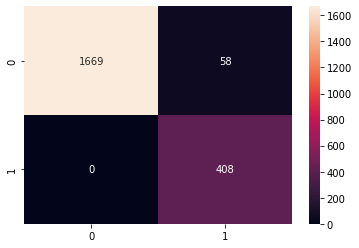

In [19]:
cm = sklearn.metrics.confusion_matrix(y_train, modelNB.predict(X_train))
sns.heatmap(cm, annot=True, fmt="d")

In [20]:
print(confusion_matrix(y_train,yTrain_pred))
print(classification_report(y_train,yTrain_pred))
print(accuracy_score(y_train,yTrain_pred))

[[1669   58]
 [   0  408]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1727
           1       0.88      1.00      0.93       408

    accuracy                           0.97      2135
   macro avg       0.94      0.98      0.96      2135
weighted avg       0.98      0.97      0.97      2135

0.9728337236533958
